**Individual Question**: “How do the costs of various housing units across different communities affect vacancy rates, and has the timeline between the two years affected those costs? Does this in turn affect vacancy rates as well and by how much?” 

# **Data Cleaning:**
- Some remaining excel cleaning was done for both the Individual Town Summaries, as well as Table 9 (Population Sizes of Communities)
    - Individual Town Summaries --> isolating "Number of Units and Vacancies by Unit Type", reformatting so it doesn't appear as a mess in csv format, and replacing % with decimal values so it can be read as a number
    - Table 9 --> Manually replaced a few town names (5 data points which were formatted weirdly) 

- Rest of Data Cleaning was done in python (demonstrated below) for tables 8 and 10:

In [46]:
# Cleaning Table 10: Population Values (this will be used for splitting communities into small, medium and large sections)
import pandas as pd
pd.options.mode.chained_assignment = None # cancels SettingWithCopyWarning on inputting the value for Grande Cache, which doesn't actually cause any issues

# read dataset csvs
table6 = pd.read_csv("Matthew's Data/Table6.csv")
table8 = pd.read_csv("Matthew's Data/Table8.csv")
table10 = pd.read_csv("Matthew's Data/table10.csv")

# from the communities in table8, get each individual community and put as list (these are communities which we have the data for)
community_names = table8["Community"].unique().tolist()

# filter the population csv based on if it exists in the observed commmunities list (those included in table 8) using .isin()
table10_byAreaNames = table10[table10["Area Name"].isin(community_names)]

# IMPUTATION: Grande Cache's population value is marked with "--", and due to its peculiar status as demoted to hamlet (https://en.wikipedia.org/wiki/Grande_Cache) , we are unable to find the population for 2022, so we will impute its 2021 population instead
# since this is just being used to divide population into bins and the way we are going to divide the population later, this will not have an effect on how we are going to use it
table10_byAreaNames.loc[table10_byAreaNames["Area Name"] == "Grande Cache"] = table10_byAreaNames.loc[table10_byAreaNames["Area Name"] == "Grande Cache"].replace("--", "3037")

# convert 2022 and 2021 column to integer values (since it is currently being read as string) with .apply()
table10_byAreaNames["2022"] = table10_byAreaNames["2022"].apply(lambda x: int(x))

# We take the most recent population for dividing into bins (2022), so we drop the 2021 population column
table10_byAreaNames.drop(["2021"],axis=1,inplace=True)

# display populations (in alphabetical order)
table10_cleaned = table10_byAreaNames.sort_values("Area Name")
table10_cleaned

#  .tolist() https://numpy.org/doc/2.2/reference/generated/numpy.ndarray.tolist.html 
# Population Table (table10.csv) exported from https://open.alberta.ca/dataset/alberta-population-estimates-data-tables 
# SettingWithCopyWarning: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas    
# .isin() method https://www.geeksforgeeks.org/how-to-check-if-pandas-column-has-value-from-list-of-string/ 
# convert to int using .apply() https://www.geeksforgeeks.org/convert-a-dataframe-column-to-integer-in-pandas/ 
# Grande Cache information (most recent population) https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/details/page.cfm?Lang=E&SearchText=Grande%20Cache&DGUIDlist=2021S05100335&GENDERlist=1,2,3&STATISTIClist=1&HEADERlist=0 

,Area Name,Type,2022
308,Athabasca,T,2827
330,Banff,T,9347
296,Barrhead,T,4503
26,Bassano,T,1255
409,Beaverlodge,T,2371
...,...,...,...
183,Vegreville,T,5819
190,Vermilion,T,3978
59,Vulcan,T,1825
131,Wainwright,T,6741


In [47]:
# Cleaning Table8: Remove table8 values where weighted rent is 0
table8 = table8[table8["2021 Weighted Rent"] != 0]
table8 = table8[table8["2022 Weighted Rent"] != 0]
table8

,Community,Unit Type,2021 Weighted Rent,2022 Weighted Rent
0,Athabasca,1 - Bedroom,840,852
1,Athabasca,2 - Bedroom,912,931
2,Athabasca,3 - Bedroom,1026,980
3,Athabasca,Bachelor,706,719
4,Banff,1 - Bedroom,1318,1435
...,...,...,...,...
247,Wainwright,Bachelor,450,434
248,Westlock,1 - Bedroom,775,768
249,Westlock,2 - Bedroom,881,881
250,Westlock,3 - Bedroom,972,963


--------------------------------------------
### **Cleaning data for individual summaries**

In [48]:
# Divide population into different sizes (approximately 1/3rds for small, medium and large population sizes)
population_labels, population_bins = pd.qcut(table10_cleaned["2022"], 3, retbins=True) # use pd.qcut to split data into 1/3rds for each size
print("Bin Divisions:",population_bins.astype(int)) # display the bin bounds (as integers as well)

# https://pandas.pydata.org/docs/reference/api/pandas.qcut.html
# https://stackoverflow.com/questions/54565805/how-to-get-the-bin-value-by-qcut 

Bin Divisions: [  719  2492  5760 14996]


This means we are going to divide the population into the following sizes *([] = Included, () = Excluded)*:
- Small: [719, 2492]
- Medium: (2492, 5760]
- Large: (5760, 14996]

In [49]:
# List of "Small Towns" (sizes 719-2,492)
small_towns = table10_cleaned[table10_cleaned["2022"].between(population_bins[0], population_bins[1])] # used .between to filter table10 to just towns in between population size 719 and 2492 (lower bound included here)
small_towns

# .between() method https://pandas.pydata.org/docs/reference/api/pandas.Series.between.html 

,Area Name,Type,2022
26,Bassano,T,1255
409,Beaverlodge,T,2371
4,Bow Island,T,2129
137,Bowden,T,1297
202,Bruderheim,T,1392
145,Eckville,T,1079
260,Elk Point,T,1455
417,Falher,T,1034
401,Fox Creek,T,1841
48,Hanna,T,2492


In [50]:
# list of "Medium Size Towns"(size 2,493-5,760)
med_towns = table10_cleaned[table10_cleaned["2022"].between(population_bins[1], population_bins[2], inclusive='right')] # filter towns by population size 2,492-5,760 (excluding lower bound)
med_towns

,Area Name,Type,2022
308,Athabasca,T,2827
296,Barrhead,T,4503
85,Black Diamond,T,2825
29,Cardston,T,3828
96,Carstairs,T,5181
38,Claresholm,T,3957
98,Didsbury,T,5172
425,Fairview,T,2914
36,Fort Macleod,T,3499
402,Grande Cache,T,3037


In [51]:
# list of "Large Towns" (size 5,761-14,996)
big_towns = table10_cleaned[table10_cleaned["2022"].between(population_bins[2], population_bins[3], inclusive='right')] # filter towns by population size 5,760-14,996 (excluding lower bound)
big_towns

,Area Name,Type,2022
330,Banff,T,9347
150,Blackfalds,T,11363
256,Bonnyville,T,6632
18,Coaldale,T,9179
322,Crowsnest Pass,SM,5910
226,Drayton Valley,T,7482
68,Drumheller,T,8231
320,Edson,T,8399
81,High River,T,14996
319,Hinton,T,9933


I sampled a few towns by community size range (small, medium, big), selecting those with various trends in rent (including how large/small compared to average and whether there is increase or decrease in rent) and how it affects both individual and overall vacancy between those two years, some which are similar and can be compared to similar towns in other sizes.

Reasons why I chose these towns based on community attributes related to rents:

<u>Small</u>:
- Fox Creek --> Rents higher than average and increasing, also wonder how this compares to slave lake which shows similar trends but is from a larger population size
- Falher --> Noticeably lower Rents than Average 
- Millet --> Less housing units, slightly higher costs 
- Mclennan --> Less housing units, lower costs than average

<u>Medium</u>:
- Jasper --> Rents are much higher than average, but experienced NO change in vacancies (0% both years)
- Claresholm --> Rents below average and has an increasing trend 
- Grimshaw --> Less housing units -> rents above average 
- Raymond --> Less housing units -> rents below average 

<u>Large</u>:
- Slave Lake --> Rents much higher than average and incresing (similar to Fox Creek)
- Ponoka --> Similar trend to High Prairie (3bed higher than others, which are closer to average) 
- Banff --> Higher rents than average and also 4+ Bedrooms -> compared to fort macleod
- Taber --> Rents below average, increase trend -> increase in vacancy -> compared with claresholm
- Edson --> Similar to Ponoka BUT rents for 1 beds,2 beds and bachelor are now noticeably above average 

-------------

In [52]:
# Tuples for multilevel index where outer is the two years and inner is the unit type
multigrouping = [("2021", "Bachelor"),("2021", "1 - Bedroom"), ("2021", "2 - Bedroom"), ("2021", "3 - Bedroom"),("2021", "4+ Bedroom"),
                  ("2022", "Bachelor"), ("2022", "1 - Bedroom"), ("2022", "2 - Bedroom"), ("2022", "3 - Bedroom"),("2022", "4+ Bedroom"),]

## Small Towns

In [53]:
# Get individual vacancies by unit for Fox Creek
# Individual Vacancies for Fox Creek in 2022
foxcreek_vacancies = pd.read_csv("Matthew's Data/Summaries/Fox Creek Summary.csv")

# Set row index as the labels - # of units, # of vacancies, and percent (vacancy rate)
foxcreek_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)

# Convert decimals to percent in "Percentage" row
foxcreek_vacancies.loc["Percentage"] = foxcreek_vacancies.loc["Percentage"].apply(lambda x: x*100)

# Add 2021 Vacancies, since they were only found in pdf form, had to manually get the values (applies to all communities, individual unit vacancies) 
foxcreek_vacancies_2021 = pd.DataFrame({
    "Bachelor": [3,0,0], 
    "1 - Bedroom":[57,28, 49.1], 
    "2 - Bedroom": [109, 62, 56.9], 
    "3 - Bedroom": [14, 5, 35.7], 
    "4+ Bedroom": [0,0,0]})

# universal "index setter" which makes the row names "Number of Units", "Vacancies", "Percentage"
attributes = foxcreek_vacancies.index

# concatenate both 2021 and 2022 vacancies into a single dataframe
foxcreek_vacancies_2021.index = attributes
foxcreek_vacancies = pd.concat([foxcreek_vacancies_2021, foxcreek_vacancies], axis=1)

# use multilevel indexing to group each unit type under year (2021, 2022) using  the "multigrouping" tuple array defined earlier
foxcreek_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
foxcreek_vacancies

# 2021 individual unit vacancies (used for all communities) https://open.alberta.ca/dataset/fb9452c6-395e-45a8-8149-645956fd83ac/resource/6637b927-5e8c-4ca1-87a1-504874487a41/download/sh-apartment-vacancy-rental-cost-survey-2021.pdf
# Concatenating dataframes https://pandas.pydata.org/docs/reference/api/pandas.concat.html  

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           3        57.0   
Vacancies                                                 0        28.0   
Percentage                                                0        49.1   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          109.0        14.0   
Vacancies                                                 62.0         5.0   
Percentage                                                56.9        35.7   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      1.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           36.0        55.0   
Vacancies                                                 21.0        35.0   
Percentage                                                58.3        63.6   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            5.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [54]:
# Get individual vacancies by unit for Falher
falher_vacancies = pd.read_csv("Matthew's Data/Summaries/Falher Summary.csv")
falher_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
falher_vacancies = falher_vacancies.dropna(how='all',axis=1)
falher_vacancies = falher_vacancies.dropna(how='all',axis=0)
falher_vacancies.loc["Percentage"] = falher_vacancies.loc["Percentage"].apply(lambda x: x*100)
falher_vacancies_2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[18,0,0], 
    "2 - Bedroom": [21, 1, 0.048], 
    "3 - Bedroom": [7, 1, 0.143], 
    "4+ Bedroom": [0,0,0]})
falher_vacancies_2021.index = attributes
falher_vacancies = pd.concat([falher_vacancies_2021, falher_vacancies], axis=1)
falher_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
falher_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2          18   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                         21.000       7.000   
Vacancies                                                1.000       1.000   
Percentage                                               0.048       0.143   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           20.0        24.0   
Vacancies                                                  3.0         2.0   
Percentage                                                15.0         8.3   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            7.0        0.0  
Vacancies                                                  1.0        0.0  
Percentage                                                14.3        0.0

In [55]:
# Get individual vacancies by unit for Millet
millet_vacancies = pd.read_csv("Matthew's Data/Summaries/Millet Summary.csv")
millet_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
millet_vacancies = millet_vacancies.dropna(how='all',axis=1)
millet_vacancies = millet_vacancies.dropna(how='all',axis=0)
millet_vacancies.loc["Percentage"] = millet_vacancies.loc["Percentage"].apply(lambda x: x*100)
millet_vacancies_2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[4,1,25], 
    "2 - Bedroom": [15,2,13.3], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})
millet_vacancies_2021.index = attributes
millet_vacancies = pd.concat([millet_vacancies_2021, millet_vacancies], axis=1)
millet_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
millet_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0           4   
Vacancies                                                 0           1   
Percentage                                                0          25   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           15.0           0   
Vacancies                                                  2.0           0   
Percentage                                                13.3           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            5.0        14.0   
Vacancies                                                  0.0         0.0   
Percentage                                                 0.0         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [56]:
# Get individual vacancies by unit for Mclennan
mclennan_vacancies = pd.read_csv("Matthew's Data/Summaries/Mclennan Summary.csv")
mclennan_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
mclennan_vacancies = mclennan_vacancies.dropna(how='all',axis=1)
mclennan_vacancies = mclennan_vacancies.dropna(how='all',axis=0)
mclennan_vacancies.loc["Percentage"] = mclennan_vacancies.loc["Percentage"].apply(lambda x: x*100)
mclennan_vacancies_2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[12,0,0], 
    "2 - Bedroom": [15,0,0], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})
mclennan_vacancies_2021.index = attributes
mclennan_vacancies = pd.concat([mclennan_vacancies_2021, mclennan_vacancies], axis=1)
mclennan_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
mclennan_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0          12   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             15           0   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           12.0        12.0   
Vacancies                                                  1.0         0.0   
Percentage                                                 8.3         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

------

# Medium Towns

In [57]:
# Get individual vacancies by unit for Jasper
# This (and banff) had to manually get the 2022 individual vacancy values from the linked pdf for since sheet didn't have it 
jasper_vacancies = pd.DataFrame({
    "Bachelor": [149,0,0], 
    "1 - Bedroom":[112,0,0], 
    "2 - Bedroom": [75,0,0], 
    "3 - Bedroom": [21,0,0], 
    "4+ Bedroom": [0,0,0]})
jasper_vacancies.index = attributes # set same row names for this custom dataframe
jasper_vacancies.loc["Percentage"] = jasper_vacancies.loc["Percentage"].apply(lambda x: x*100)
jasper_vacancies2021 = pd.DataFrame({
    "Bachelor": [147,0,0], 
    "1 - Bedroom":[82,0,0], 
    "2 - Bedroom": [26,0,0], 
    "3 - Bedroom": [2,0,0], 
    "4+ Bedroom": [0,0,0]})
jasper_vacancies2021.index = attributes
jasper_vacancies = pd.concat([jasper_vacancies2021, jasper_vacancies], axis=1)
jasper_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
jasper_vacancies

# pdf for 2022 individual vacancies: (https://open.alberta.ca/dataset/fb9452c6-395e-45a8-8149-645956fd83ac/resource/e07f0421-a710-4c3c-9bbf-392285493e6b/download/scss-apartment-vacancy-rental-cost-survey-2022.pdf) 

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                         147          82   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             26           2   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      149   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            112          75   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                             21          0  
Vacancies                                                    0          0  
Percentage                                                   0          0

In [58]:
# Get individual vacancies by unit for Claresholm
claresholm_vacancies = pd.read_csv("Matthew's Data/Summaries/Claresholm Summary.csv")
claresholm_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
claresholm_vacancies = claresholm_vacancies.dropna(how='all',axis=1)
claresholm_vacancies = claresholm_vacancies.dropna(how='all',axis=0)
claresholm_vacancies.loc["Percentage"] = claresholm_vacancies.loc["Percentage"].apply(lambda x: x*100)
claresholm_vacancies2021 = pd.DataFrame({
    "Bachelor": [16,0,0], 
    "1 - Bedroom":[6,0,0], 
    "2 - Bedroom": [29,0,0], 
    "3 - Bedroom": [8,0,0], 
    "4+ Bedroom": [0,0,0]})
claresholm_vacancies2021.index = attributes
claresholm_vacancies = pd.concat([claresholm_vacancies2021, claresholm_vacancies], axis=1)
claresholm_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
claresholm_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                          16           6   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             29           8   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      1.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           12.0        52.0   
Vacancies                                                  0.0         1.0   
Percentage                                                 0.0         1.9   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            8.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [59]:
# Get individual vacancies by unit for Grimshaw
grimshaw_vacancies = pd.read_csv("Matthew's Data/Summaries/Grimshaw Summary.csv")
grimshaw_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
grimshaw_vacancies = grimshaw_vacancies.dropna(how='all',axis=1)
grimshaw_vacancies = grimshaw_vacancies.dropna(how='all',axis=0)
grimshaw_vacancies.loc["Percentage"] = grimshaw_vacancies.loc["Percentage"].apply(lambda x: x*100)
grimshaw_vacancies2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[9,0,0], 
    "2 - Bedroom": [51,5,9.8], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})
grimshaw_vacancies2021.index = attributes
grimshaw_vacancies = pd.concat([grimshaw_vacancies2021, grimshaw_vacancies], axis=1)
grimshaw_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
grimshaw_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0           9   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           51.0           0   
Vacancies                                                  5.0           0   
Percentage                                                 9.8           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           10.0        38.0   
Vacancies                                                  0.0         4.0   
Percentage                                                 0.0        10.5   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

In [60]:
# Get individual vacancies by unit for Raymond
raymond_vacancies = pd.read_csv("Matthew's Data/Summaries/Raymond Summary.csv")
raymond_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
raymond_vacancies = raymond_vacancies.dropna(how='all',axis=1)
raymond_vacancies = raymond_vacancies.dropna(how='all',axis=0)
raymond_vacancies.loc["Percentage"] = raymond_vacancies.loc["Percentage"].apply(lambda x: x*100)
raymond_vacancies2021 = pd.DataFrame({
    "Bachelor": [0,0,0], 
    "1 - Bedroom":[2,2,1], 
    "2 - Bedroom": [8,0,0], 
    "3 - Bedroom": [0,0,0], 
    "4+ Bedroom": [0,0,0]})
raymond_vacancies2021.index = attributes
raymond_vacancies = pd.concat([raymond_vacancies2021, raymond_vacancies], axis=1)
raymond_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
raymond_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           0           2   
Vacancies                                                 0           2   
Percentage                                                0           1   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                              8           0   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      0.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                            2.0         2.0   
Vacancies                                                  0.0         0.0   
Percentage                                                 0.0         0.0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                            0.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

----------

# Big Towns

In [61]:
# Get individual vacancies by unit for Slave Lake
slavelake_vacancies = pd.read_csv("Matthew's Data/Summaries/Slave Lake Summary.csv")
slavelake_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
slavelake_vacancies = slavelake_vacancies.dropna(how='all',axis=1)
slavelake_vacancies = slavelake_vacancies.dropna(how='all',axis=0)
slavelake_vacancies.loc["Percentage"] = slavelake_vacancies.loc["Percentage"].apply(lambda x: x*100)
slavelake_vacancies2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[19,0,0], 
    "2 - Bedroom": [27,0,0], 
    "3 - Bedroom": [64,0,0], 
    "4+ Bedroom": [0,0,0]})
slavelake_vacancies2021.index = attributes
slavelake_vacancies = pd.concat([slavelake_vacancies2021, slavelake_vacancies], axis=1)
slavelake_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
slavelake_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2          19   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                             27          64   
Vacancies                                                    0           0   
Percentage                                                   0           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      6.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           57.0       105.0   
Vacancies                                                  2.0         3.0   
Percentage                                                 3.5         2.9   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           96.0        0.0  
Vacancies                                                 13.0        0.0  
Percentage                                                13.5        0.0

In [62]:
# Get individual vacancies by unit for Ponoka
ponoka_vacancies = pd.read_csv("Matthew's Data/Summaries/Ponoka Summary.csv")
ponoka_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
ponoka_vacancies = ponoka_vacancies.dropna(how='all',axis=1)
ponoka_vacancies = ponoka_vacancies.dropna(how='all',axis=0)
ponoka_vacancies.loc["Percentage"] = ponoka_vacancies.loc["Percentage"].apply(lambda x: x*100)
ponoka_vacancies2021 = pd.DataFrame({
    "Bachelor": [8,3,37.5], 
    "1 - Bedroom":[51,6,11.8], 
    "2 - Bedroom": [134,11,8.2], 
    "3 - Bedroom": [23,2,8.7], 
    "4+ Bedroom": [0,0,0]})
ponoka_vacancies2021.index = attributes
ponoka_vacancies = pd.concat([ponoka_vacancies2021, ponoka_vacancies], axis=1)
ponoka_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
ponoka_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                         8.0        51.0   
Vacancies                                               3.0         6.0   
Percentage                                             37.5        11.8   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          134.0        23.0   
Vacancies                                                 11.0         2.0   
Percentage                                                 8.2         8.7   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      5.0   
Vacancies                                                   0      1.0   
Percentage                                                  0     20.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           54.0       141.0   
Vacancies                                                  1.0         3.0   
Percentage                                                 1.9         2.1   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           18.0        0.0  
Vacancies                                                  4.0        0.0  
Percentage                                                22.2        0.0

In [63]:
# Get individual vacancies by unit for Banff (also had manually extract data from the 2022 pdf from Jasper section)
banff_vacancies = pd.DataFrame({
    "Bachelor": [12,0,0], 
    "1 - Bedroom":[91,1,1.1], 
    "2 - Bedroom": [179,0,0], 
    "3 - Bedroom": [94,0,0], 
    "4+ Bedroom": [2,0,0]})
banff_vacancies.index = attributes
banff_vacancies2021 = pd.DataFrame({
    "Bachelor": [51,0,0], 
    "1 - Bedroom":[99,2,2], 
    "2 - Bedroom": [133,7,5.3], 
    "3 - Bedroom": [58,0,3.4], 
    "4+ Bedroom": [2,0,0]})
banff_vacancies2021.index = attributes
banff_vacancies = pd.concat([banff_vacancies2021, banff_vacancies], axis=1)
banff_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
banff_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                          51          99   
Vacancies                                                 0           2   
Percentage                                                0           2   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          133.0        58.0   
Vacancies                                                  7.0         0.0   
Percentage                                                 5.3         3.4   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             2       12   
Vacancies                                                   0        0   
Percentage                                                  0        0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           91.0         179   
Vacancies                                                  1.0           0   
Percentage                                                 1.1           0   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                             94          2  
Vacancies                                                    0          0  
Percentage                                                   0          0

In [64]:
# Get individual vacancies by unit for Taber
taber_vacancies = pd.read_csv("Matthew's Data/Summaries/Taber Summary.csv")
taber_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
taber_vacancies = taber_vacancies.dropna(how='all',axis=1)
taber_vacancies = taber_vacancies.dropna(how='all',axis=0)
taber_vacancies.loc["Percentage"] = taber_vacancies.loc["Percentage"].apply(lambda x: x*100)
taber_vacancies2021 = pd.DataFrame({
    "Bachelor": [1,0,0], 
    "1 - Bedroom":[21,0,0], 
    "2 - Bedroom": [64,1,1.6], 
    "3 - Bedroom": [24,1,4.2], 
    "4+ Bedroom": [0,0,0]})
taber_vacancies2021.index = attributes
taber_vacancies = pd.concat([taber_vacancies2021, taber_vacancies], axis=1)
taber_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
taber_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           1          21   
Vacancies                                                 0           0   
Percentage                                                0           0   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           64.0        24.0   
Vacancies                                                  1.0         1.0   
Percentage                                                 1.6         4.2   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           38.0       105.0   
Vacancies                                                  0.0         6.0   
Percentage                                                 0.0         5.7   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           37.0        0.0  
Vacancies                                                  2.0        0.0  
Percentage                                                 5.4        0.0

In [65]:
# Get individual vacancies by unit for Edson
edson_vacancies = pd.read_csv("Matthew's Data/Summaries/Edson Summary.csv")
edson_vacancies.set_index("Number and Percentage of Vacancies by Type of Unit", inplace=True)
edson_vacancies = edson_vacancies.dropna(how='all',axis=1)
edson_vacancies = edson_vacancies.dropna(how='all',axis=0)
edson_vacancies.loc["Percentage"] = edson_vacancies.loc["Percentage"].apply(lambda x: x*100)
edson_vacancies2021 = pd.DataFrame({
    "Bachelor": [2,0,0], 
    "1 - Bedroom":[69,3,4.3], 
    "2 - Bedroom": [165,1,0.6], 
    "3 - Bedroom": [16,0,0], 
    "4+ Bedroom": [0,0,0]})
edson_vacancies2021.index = attributes
edson_vacancies = pd.concat([edson_vacancies2021, edson_vacancies], axis=1)
edson_vacancies.columns = pd.MultiIndex.from_tuples(multigrouping)
edson_vacancies

2021              \
                                                   Bachelor 1 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                        
Number of Units                                           2        69.0   
Vacancies                                                 0         3.0   
Percentage                                                0         4.3   

                                                                            \
                                                   2 - Bedroom 3 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                          165.0          16   
Vacancies                                                  1.0           0   
Percentage                                                 0.6           0   

                                                                  2022  \
                                                   4+ Bedroom Bachelor   
Number and Percentage of Vacancies by Type of Unit                       
Number of Units                                             0      2.0   
Vacancies                                                   0      0.0   
Percentage                                                  0      0.0   

                                                                            \
                                                   1 - Bedroom 2 - Bedroom   
Number and Percentage of Vacancies by Type of Unit                           
Number of Units                                           75.0       214.0   
Vacancies                                                  3.0        11.0   
Percentage                                                 4.0         5.1   

                                                                           
                                                   3 - Bedroom 4+ Bedroom  
Number and Percentage of Vacancies by Type of Unit                         
Number of Units                                           34.0        0.0  
Vacancies                                                  0.0        0.0  
Percentage                                                 0.0        0.0

-------

# **Visualizations + Analysis:**

In [66]:
import matplotlib.pyplot as plt
import numpy as np

In [67]:
# get mean rent by each unit type for both 2021 and 2022
mean_bachelors2022 = table8[table8["Unit Type"] == "Bachelor"]["2022 Weighted Rent"].mean()
mean_1beds2022 = table8[table8["Unit Type"] == "1 - Bedroom"]["2022 Weighted Rent"].mean()
mean_2beds2022 = table8[table8["Unit Type"] == "2 - Bedroom"]["2022 Weighted Rent"].mean()
mean_3beds2022 = table8[table8["Unit Type"] == "3 - Bedroom"]["2022 Weighted Rent"].mean()
mean_4beds2022 = table8[table8["Unit Type"] == "4+ Bedroom"]["2022 Weighted Rent"].mean()

mean_bachelors2021 = table8[table8["Unit Type"] == "Bachelor"]["2021 Weighted Rent"].mean()
mean_1beds2021 = table8[table8["Unit Type"] == "1 - Bedroom"]["2021 Weighted Rent"].mean()
mean_2beds2021 = table8[table8["Unit Type"] == "2 - Bedroom"]["2021 Weighted Rent"].mean()
mean_3beds2021 = table8[table8["Unit Type"] == "3 - Bedroom"]["2021 Weighted Rent"].mean()
mean_4beds2021 = table8[table8["Unit Type"] == "4+ Bedroom"]["2021 Weighted Rent"].mean()

# Display Results
print("2021 Mean Bachelor Rents:",mean_bachelors2021)
print("2021 Mean 1 - Bedroom Rents:",mean_1beds2021)
print("2021 Mean 2 - Bedroom Rents:",mean_2beds2021)
print("2021 Mean 3 - Bedroom Rents:",mean_3beds2021)
print("2021 Mean 4+ Bedroom Rents:",mean_4beds2021)
print()
print("2022 Mean Bachelor Rents:",mean_bachelors2022)
print("2022 Mean 1 - Bedroom Rents:",mean_1beds2022)
print("2022 Mean 2 - Bedroom Rents:",mean_2beds2022)
print("2022 Mean 3 - Bedroom Rents:",mean_3beds2022)
print("2022 Mean 4+ Bedroom Rents:",mean_4beds2022)

2021 Mean Bachelor Rents: 688.741935483871
2021 Mean 1 - Bedroom Rents: 779.925925925926
2021 Mean 2 - Bedroom Rents: 900.6101694915254
2021 Mean 3 - Bedroom Rents: 1036.625
2021 Mean 4+ Bedroom Rents: 1625.0

2022 Mean Bachelor Rents: 702.741935483871
2022 Mean 1 - Bedroom Rents: 826.0
2022 Mean 2 - Bedroom Rents: 943.1186440677966
2022 Mean 3 - Bedroom Rents: 1064.6041666666667
2022 Mean 4+ Bedroom Rents: 1708.6


In [ ]:
# helper function for graphing average rents between 2021 and 2022 on line graph, input is whether the unit type exists, and plots line graph of mean between 2021-2022 if it does
def plotmeans(bach,one,two,three,four):
    if bach == True:
        color = ""
        if four == True: 
            color = "purple"
        else: 
            color = "r"
        plt.plot([mean_bachelors2021, mean_bachelors2022], linestyle='dotted', color=color)
    if one == True:
        plt.plot([mean_1beds2021, mean_1beds2022], linestyle='dotted', color="b")
    if two == True:
        plt.plot([mean_2beds2021, mean_2beds2022], linestyle='dotted', color="orange")
    if three == True:
        plt.plot([mean_3beds2021, mean_3beds2022], linestyle='dotted', color="g")
    if four == True:
        plt.plot([mean_4beds2021, mean_4beds2022], linestyle='dotted', color="r")

# helper function for graphing individual vacancy bargraphs
def barGraph(town_vacancies, town_name):
    vacancy_2021, vacancy_2022 = np.array(town_vacancies["2021"].loc["Vacancies"]), np.array(town_vacancies["2022"].loc["Vacancies"])
    num_units_2021, num_units_2022 = np.array(town_vacancies["2021"].loc["Number of Units"]), np.array(town_vacancies["2022"].loc["Number of Units"])
    
    x_range = np.arange(len(town_vacancies["2021"].columns))
    plt.bar(x_range - 0.2, vacancy_2021, 0.4, label="# of Vacant Units (2021)")
    plt.bar(x_range - 0.2, num_units_2021 - vacancy_2021, 0.4, bottom=vacancy_2021, alpha=0.4)
    plt.bar(x_range + 0.2, vacancy_2022, 0.4, color="C2", label="# of Vacant Units (2022)")
    plt.bar(x_range + 0.2, num_units_2022 - vacancy_2022, 0.4, bottom=vacancy_2022, alpha=0.4, color="C1")
    plt.title(f"Vacancy Rates by Unit Type ({town_name})")
    plt.xlabel("Unit Type")
    plt.ylabel("# of Units")
    plt.xticks(x_range, labels=town_vacancies["2021"].columns)
    plt.legend()
    plt.show()

# helper function for graphing rent line graphs
def lineGraph(town_rents, town_name):
    for i in range(len(town_rents.index)):
        plt.plot(["2021", "2022"], town_rents[["2021 Weighted Rent", "2022 Weighted Rent"]].iloc[i], label=town_rents["Unit Type"].iloc[i])
    plt.title(f"Weighted Rents 2021-2022 - {town_name}") 
    plt.xlabel("Year")
    plt.ylabel("Weighted Rent ($)")
    plt.legend(bbox_to_anchor=(1,1)) # puts legend outside of the graph
    plt.show()

# change legend position: https://betterstack.com/community/questions/how-to-put-the-legend-outside-the-plot/ 
# help with doing stacked bar for bargraph function: https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/  

--------------

## **Analysis of Small Communities**

In [69]:
smalltowns = ["Fox Creek", "Falher", "Millet", "Mclennan"] # Create list of all small communities we are going to sample
costs_smalltowns, vacancy_smalltowns = table8[table8["Community"].isin(smalltowns)], table6[table6["Community"].isin(smalltowns)] # Create column copies of "communities" columns from table8 and table6, filtered by if they are in smalltowns list

# create columns from cost_smalltowns (copy of table8 community) filtered by each town in smalltowns
foxcreek = costs_smalltowns[costs_smalltowns["Community"] == "Fox Creek"]
falher = costs_smalltowns[costs_smalltowns["Community"] == "Falher"] 
millet = costs_smalltowns[costs_smalltowns["Community"] == "Millet"] 
mclennan = costs_smalltowns[costs_smalltowns["Community"] == "Mclennan"]

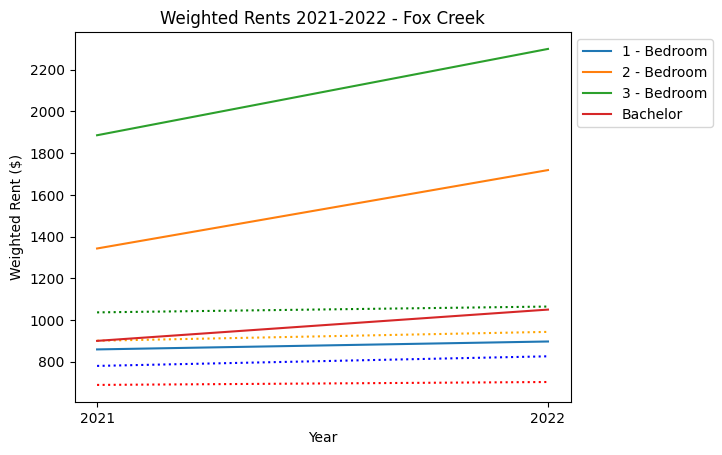

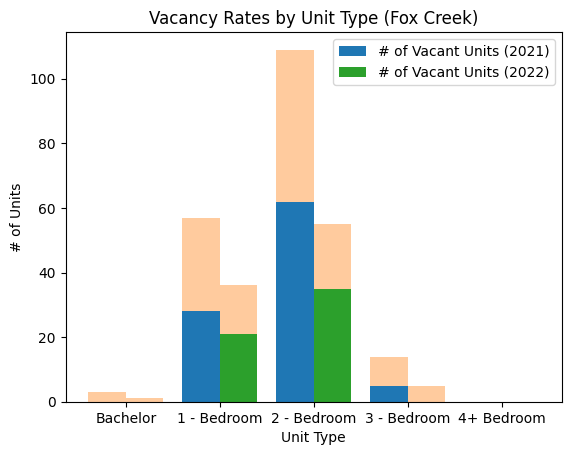

In [70]:
plotmeans(True, True, True, True, False) # plot lines of average rents for each unit type
lineGraph(foxcreek, "Fox Creek") # plot lines of weighted rent by unit type
barGraph(foxcreek_vacancies, "Fox Creek") # plot bargraph with individual vacancies

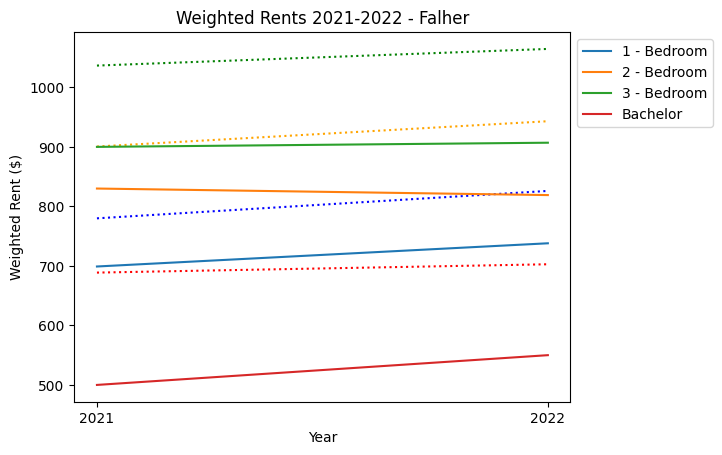

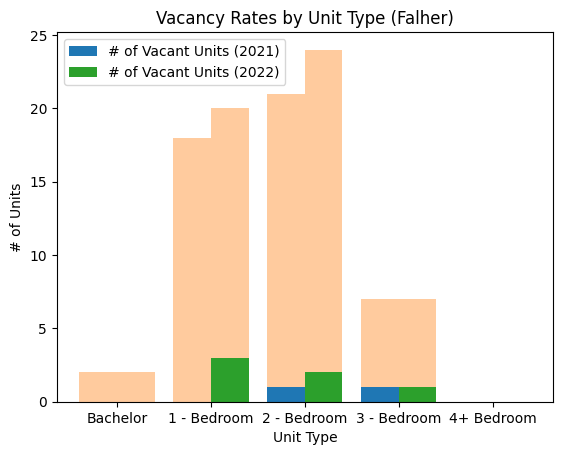

In [71]:
plotmeans(True, True, True, True, False)
lineGraph(falher, "Falher")
barGraph(falher_vacancies, "Falher")

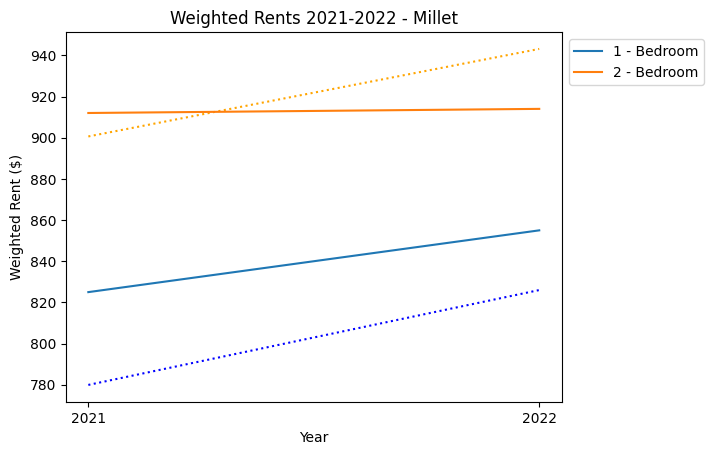

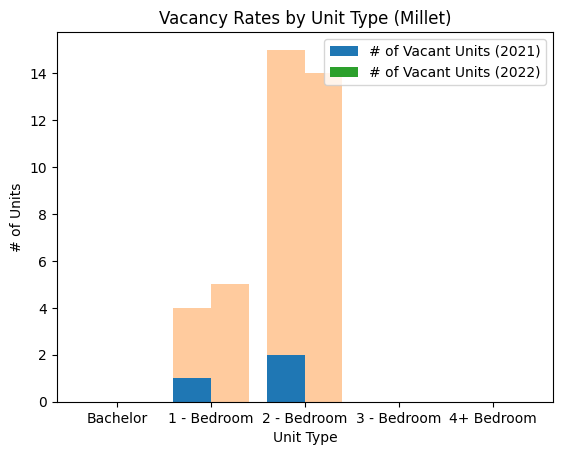

In [72]:
plotmeans(False, True, True, False, False)
lineGraph(millet, "Millet")
barGraph(millet_vacancies, "Millet")

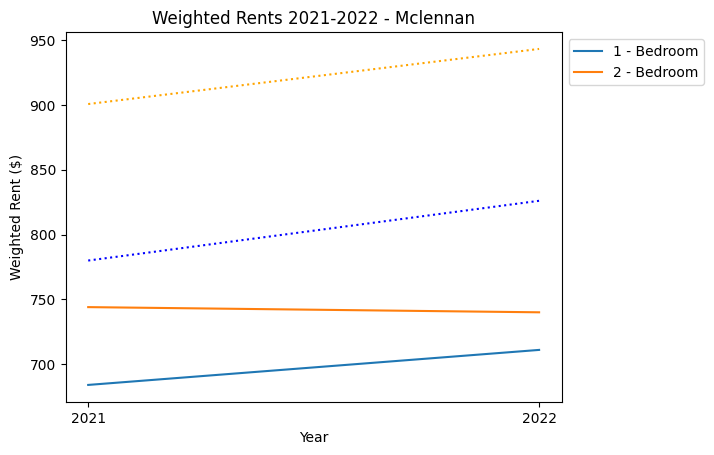

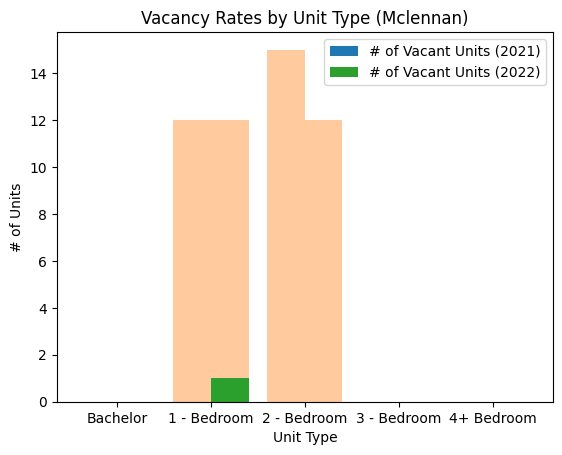

In [73]:
plotmeans(False, True, True, False, False)
lineGraph(mclennan, "Mclennan")
barGraph(mclennan_vacancies, "Mclennan")

### Overall Vacancy Rates between 2021-2022

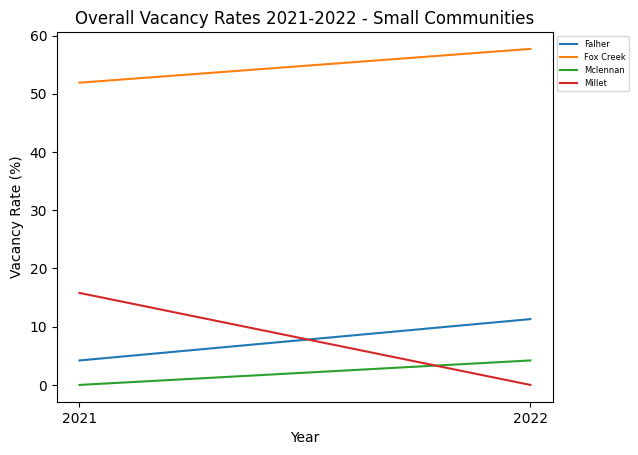

In [74]:
vacancy_smalltowns_num = vacancy_smalltowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_smalltowns.index)):
    plt.plot(["2021", "2022"], vacancy_smalltowns_num.iloc[i], label=vacancy_smalltowns["Community"].iloc[i])
plt.title("Overall Vacancy Rates 2021-2022 - Small Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

---------------------------------

## **Analysis of Medium Communities**

In [75]:
medtowns = ["Jasper", "Claresholm", "Grimshaw", "Raymond"]
costs_medtowns, vacancy_medtowns = table8[table8["Community"].isin(medtowns)], table6[table6["Community"].isin(medtowns)]

jasper = costs_medtowns[costs_medtowns["Community"] == "Jasper"]
claresholm = costs_medtowns[costs_medtowns["Community"] == "Claresholm"]
grimshaw = costs_medtowns[costs_medtowns["Community"] == "Grimshaw"]
raymond = costs_medtowns[costs_medtowns["Community"] == "Raymond"]

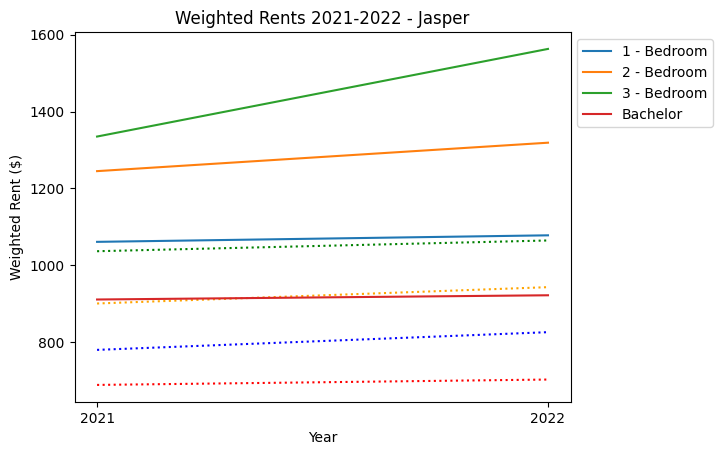

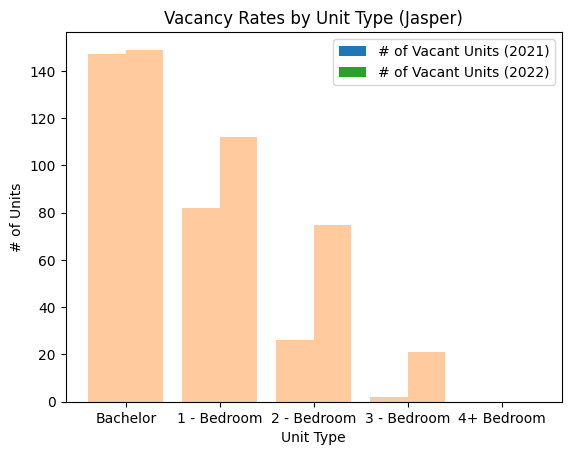

In [76]:
plotmeans(True, True, True, True, False)
lineGraph(jasper, "Jasper")
barGraph(jasper_vacancies, "Jasper")

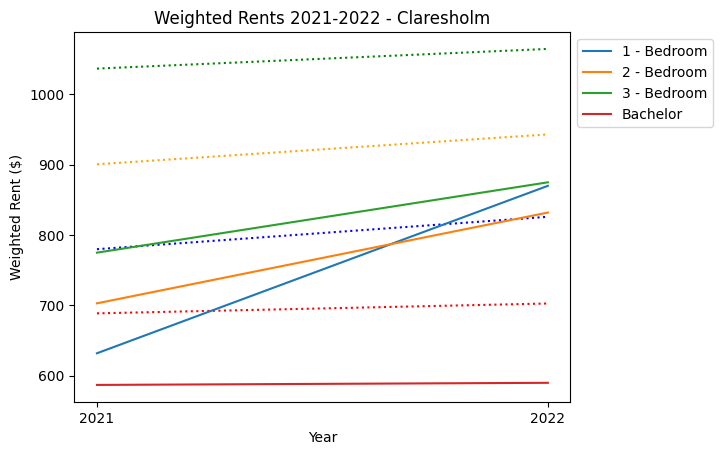

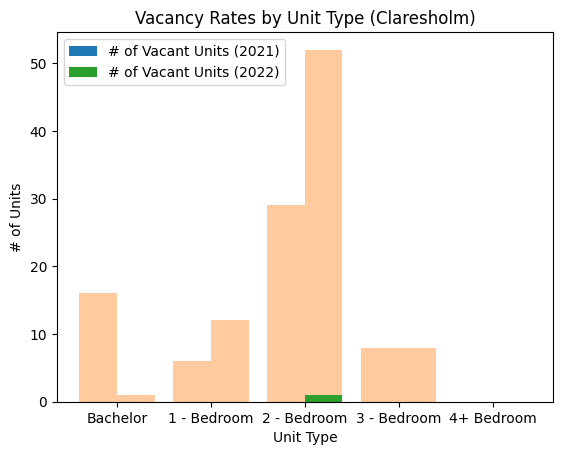

In [77]:
plotmeans(True, True, True, True, False)
lineGraph(claresholm, "Claresholm")
barGraph(claresholm_vacancies, "Claresholm")

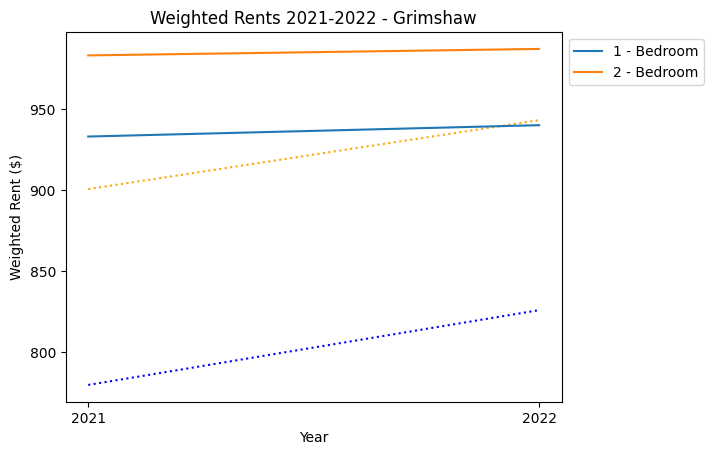

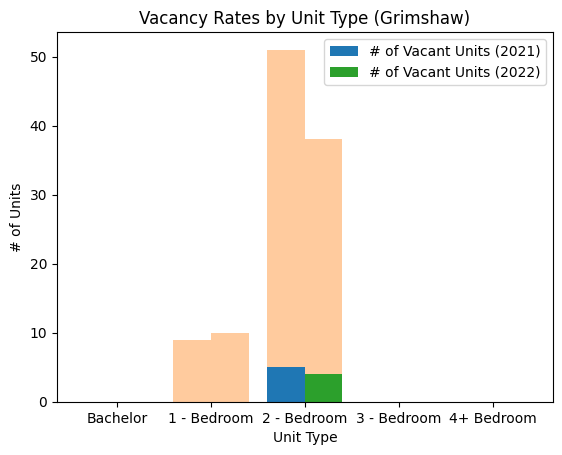

In [78]:
plotmeans(False, True, True, False, False)
lineGraph(grimshaw, "Grimshaw")
barGraph(grimshaw_vacancies, "Grimshaw")

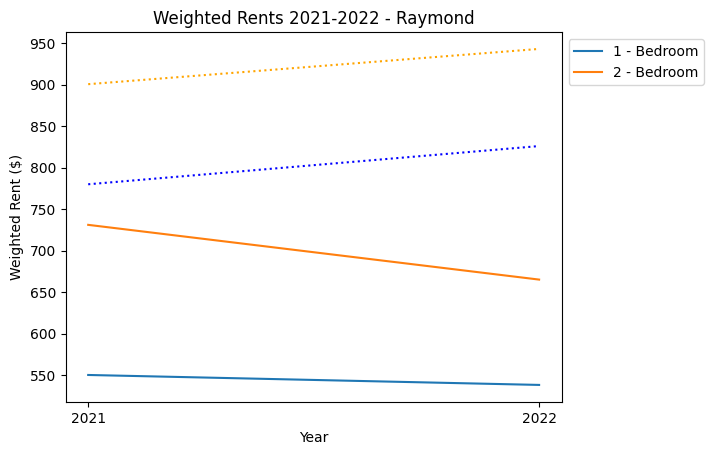

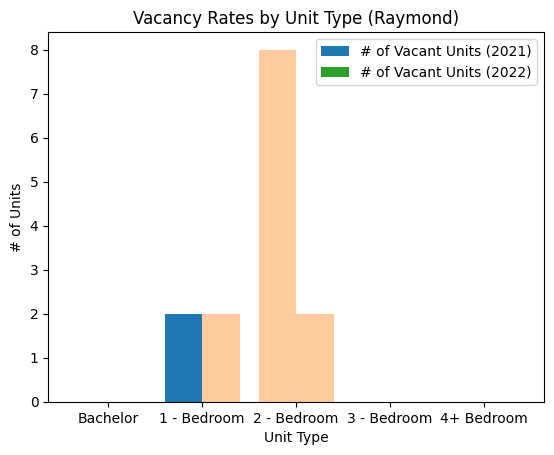

In [79]:
plotmeans(False, True, True, False, False)
lineGraph(raymond, "Raymond")
barGraph(raymond_vacancies, "Raymond")

### Overall Vacancy Rates between 2021-2022

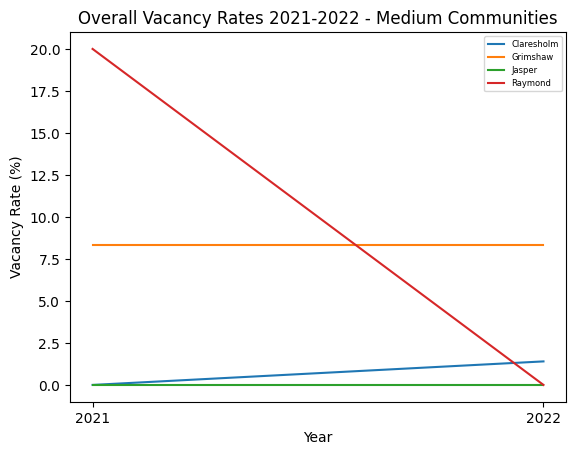

In [80]:
vacancy_medtowns_num = vacancy_medtowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_medtowns.index)):
    plt.plot(["2021", "2022"], vacancy_medtowns_num.iloc[i], label=vacancy_medtowns["Community"].iloc[i])
plt.title("Overall Vacancy Rates 2021-2022 - Medium Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

----------------------------------
## **Analysis of Large Communities**

In [81]:
bigtowns = ["Slave Lake", "Ponoka", "Banff","Taber", "Edson"]
costs_bigtowns, vacancy_bigtowns = table8[table8["Community"].isin(bigtowns)], table6[table6["Community"].isin(bigtowns)]

slavelake = costs_bigtowns[costs_bigtowns["Community"] == "Slave Lake"]
ponoka = costs_bigtowns[costs_bigtowns["Community"] == "Ponoka"] 
banff = costs_bigtowns[costs_bigtowns["Community"] == "Banff"]
taber = costs_bigtowns[costs_bigtowns["Community"] == "Taber"] 
edson = costs_bigtowns[costs_bigtowns["Community"] == "Edson"] 

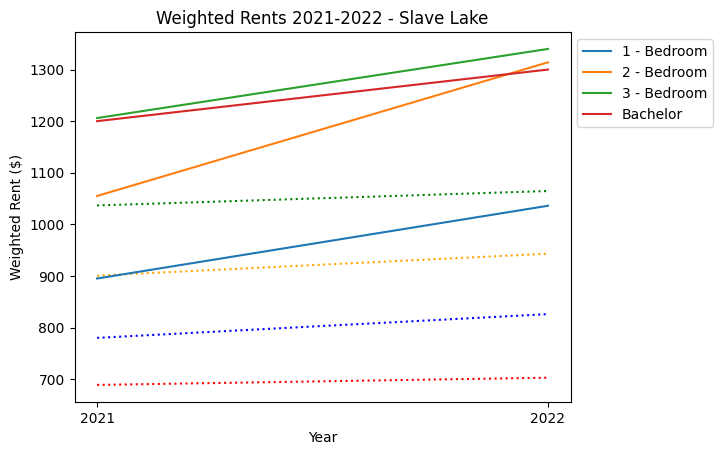

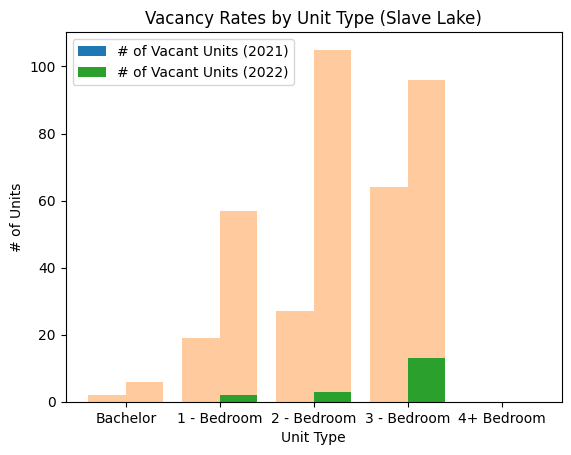

In [82]:
plotmeans(True, True, True, True, False)
lineGraph(slavelake, "Slave Lake")
barGraph(slavelake_vacancies, "Slave Lake")

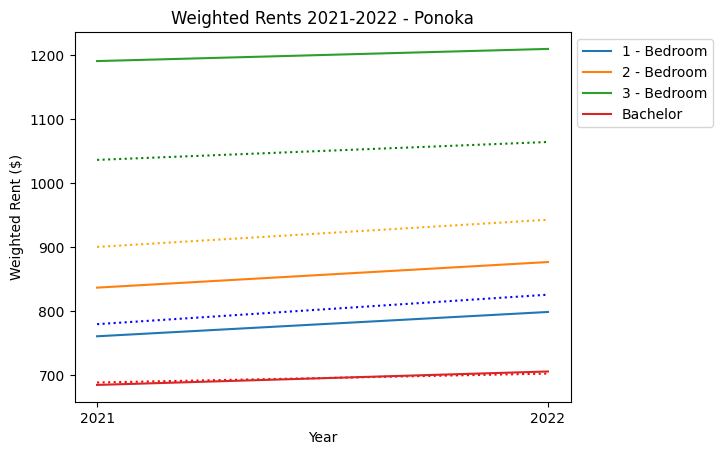

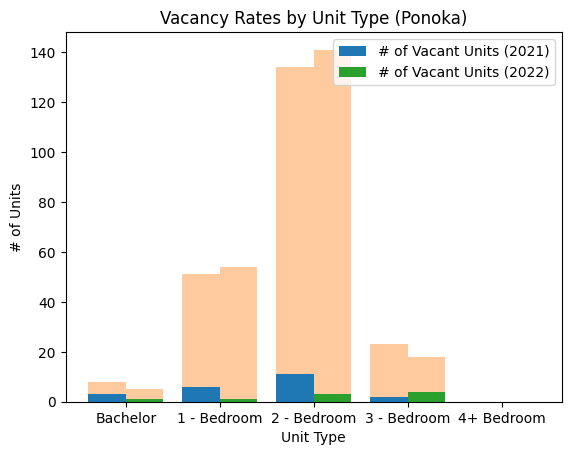

In [83]:
plotmeans(True, True, True, True, False)
lineGraph(ponoka, "Ponoka")
barGraph(ponoka_vacancies, "Ponoka")

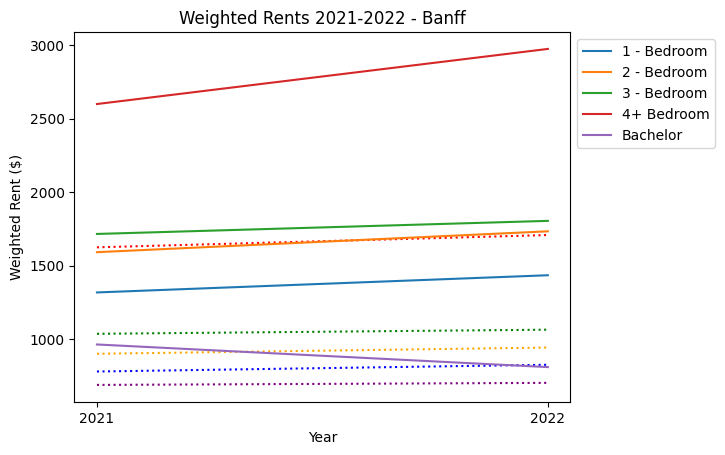

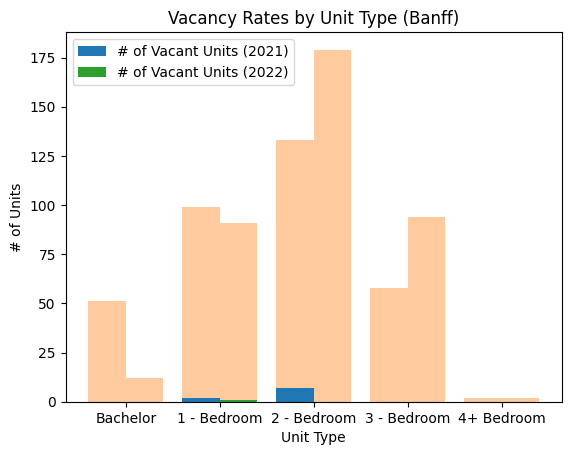

In [84]:
plotmeans(True, True, True, True, True)
lineGraph(banff, "Banff")
barGraph(banff_vacancies, "Banff")

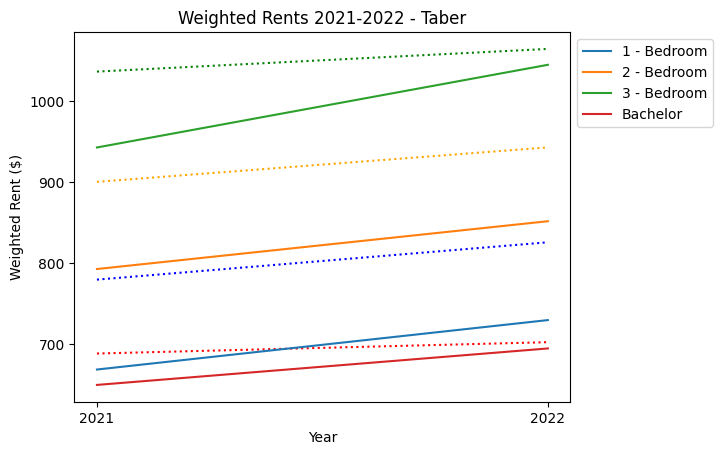

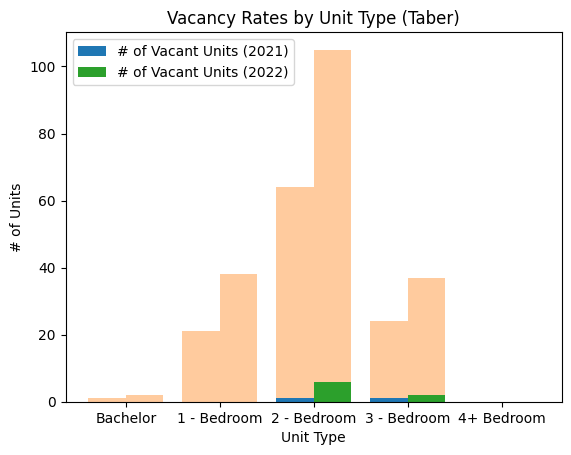

In [85]:
plotmeans(True, True, True, True, False)
lineGraph(taber, "Taber")
barGraph(taber_vacancies, "Taber")

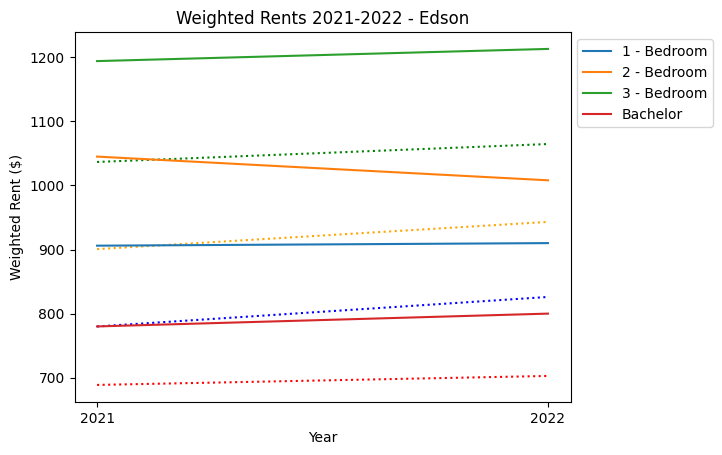

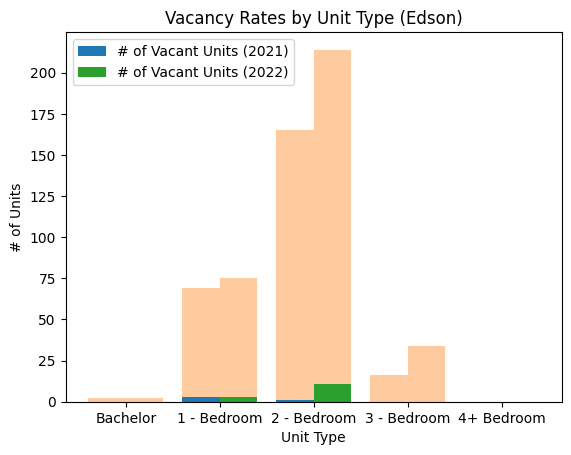

In [86]:
plotmeans(True, True, True, True, False)
lineGraph(edson, "Edson")
barGraph(edson_vacancies, "Edson")

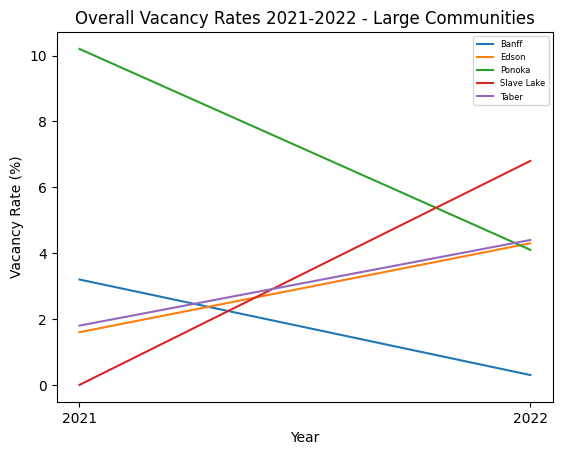

In [87]:
vacancy_bigtowns_num = vacancy_bigtowns[["2021 Vacancy", "2022 Vacancy"]]
for i in range(len(vacancy_bigtowns.index)):
    plt.plot(["2021", "2022"], vacancy_bigtowns_num.iloc[i], label=vacancy_bigtowns["Community"].iloc[i])
plt.title("Overall Vacancy Rates 2021-2022 - Large Communities") 
plt.xlabel("Year")
plt.ylabel("Vacancy Rate (%)")
plt.legend(prop={'size': 6}, bbox_to_anchor=(1,1))
plt.show()

**Fox Creek (Small) vs Slave Lake (Big)**
- Fox Creek & Slave Lake both have very **high rental prices above average** and experienced a **general increase in average rents** for all units between 2021-2022
- Both communities experienced both an **overall increase in vacancy rate**, as well as **increase in vacancy rates of most individual units** between these years
- The number of units in Fox Creek drastically dropped in 2022
    - Fox Creek had a pretty high vacancy rate before and increased even more since then (51.9% to 57.7%)

- The number of units in Slave Lake drastically increased in 2021
    - Slave Lake had no vacancies (0%) in 2021 but experienced slight increase in vacancies and overall vacancy in 2022 (0% to 6.8%)

- (Potential Connect with Asees section) since he mentioned that Slave Lake is a special case since it is generally used as a resource town. 
- Fox Creek is also known for it being a business hub for Transportation, Warehousing, Oil and Gas, and Utilities (https://regionaldashboard.alberta.ca/region/fox-creek/#/)
    - For these types of towns, increase in vacancies and average rent is likely more influenced by how these towns are used, since these mainly attract people looking for jobs in these spectrums, which implies many of the units will only be temporarily used for example.
        - Also, due to the limited number of units and many people moving into here for work, this creates an increased demand for housing with a limited supply, which can push up rental prices quite a bit. 
        - In 2021-2022 when people were recovering from the COVID-19 Pandemic and everyone is going back to jobs, this can amplify the effect even further
    - Fox Creek being a smaller community size would be more sensitive to these changes, hence the much higher vacancy rates 
    - Slave Lake being a larger community size would be less sensitive and since there is an increase in housing in 2022, there would be some permanent residence or people staying longer than the given timeframe, so changes may not be as drastic.

- <b><u>Ultimate Conclustion Here</u></b>: In resource towns such as these, higher prices do correlate with higher vacancies, but more so out of the influence of it being a resource town, which has other factors increasing both rent and vacancies

<br>

**Jasper (Medium) and Banff (Big)**
- Very high average rent for all unit types (significantly above average) for both rental units
- Jasper, experienced **no change in vacancy** and had a **0% vacancy rate over all units** and Banff experienced only a **2.9% decrease in vacancies** → *very little change in vacancies while having high rents* 
- Jasper and Banff are usually considered popular tourist destinations, hence there are usually going to be a lot of people coming in every year
which means there will usually be a very low amount of vacancies.
- Because there will usually be more people than how many units can hold, especially in 2021-2022 when the world is recovering from COVID-19 and people start travelling again, demand sometimes overcomes the housing supply which can push prices up (similar to Fox Creek vs Slave Lake)
    - With smaller number of units, like 3-beds in Jasper or 4+ bedrooms in Banff, this increase is much more significant
    - When there were increases in # of units the rents experienced much less significant change in rents

- <b><u>Ultimate Conclustion Here</u></b>: Communities like Banff or Jasper have generally high rents similar to Slave Lake or Fox Creek, but very low vacancies because of it being tourist spots

<br>

**Edson and Ponoka (both Big)**
- Edson and Ponoka both have a 3-bed unit that is higher than average 3-bedroom rent for both years
    - Edson’s other units have **higher rents than average but generally decreased a bit in 2022**
    - Ponoka’s other units have **lower rents than average but generally increased a bit in 2022**
- **Edson experienced an increase in vacancy rate** from 1.6% to 4.3%, while **Ponoka experienced a drop in vacancy rate** from 10.2% to 4.1%
    - Edson 1-bed kept the same vacancy rate (not 0) for both years, and vacancy only increased in the 2-bedroom unit in 2022
    - Ponoka had quite a few vacant units in 2021 for all units, which decreased for all except for 3-bedroom unit which increased slightly

- <b><u>Ultimate Conclustion Here</u></b>: 

<br>

**Millet/Mclennan (Small) vs Grimshaw/Raymond (Medium)**
- Millet/Mclennan and Grimshaw/Raymond are communities with less housing unit types (only 1 or 2 bed units)
- <u>Millet vs Mclennan (small)</u>:
    - Millet has **average rent/slightly higher rent than average** 
        - Experienced a **decrease in vacancy rate** (down to 0%) -> 0 vacancies in all units in 2022
    - Mclennan has **below average rent**
        - Experienced a **slight increase in vacancy rate** 
        - 0 vacancies in 2021, and slight increase in 1-bed vacancy in 2022

- <u> Grimshaw vs Raymond (medium)</u>:
    - Grimshaw has **higher rent than average** 
        - Experienced **no change in vacancy rate** 
        - 1-bed had 0 vacancies both years, and 2-bed has the same vacancy rate. but just with less # of units in 2022 (same ratio)
    - Raynond has **below average rent**
        - Experienced a **decrease in vacancy rate** to 0%
        - Almost 100% vacant units for 1-beds in 2021, then drops to 0% -> This is more of a result of very few number of units overall in Raymond
        - 2-bed has 0% for all years
        - 2-bed prices also decreased

- <b><u>Ultimate Conclustion Here</u></b>: These examples show how sensitive vacancies are with less housing unit types, which corresponds with usually less units which influences this. With really small cases like these, <u>Rental Prices don't correlate much or affect Vacancies here</u>.

<br> 
 
**Taber (Big) vs Claresholm (Medium)**
- Both communities have rent for all units below average, but display an increasing trend in rents 
- Claresholm experienced an **increase in vacancy rate** from 0% to 1.4% 
    - All units were not vacant in 2021 and in 2022 only the 3-bed unit had a slight increase in vacancy (rest were still all occupied)
    - Except for bachelors and 3-bed, experienced increase in number of units for most of the other units as well.
- Taber also experienced an **increase in vacancy rate** from 1.8% to 4.4%
    - Increase in number of units for all units in 2022, and vacancies occurred in 2-bed and 3-bed units

- Both are towns known for being popular for agriculture
- <b><u>Ultimate Conclustion Here</u></b>: 

<br>
<br>

**Thus far, the general results say that there tends to be some relation between how high or low Rent is there overall/increase or decrease in it (between these 2 years), and vacancies, HOWEVER, the kind of relation greatly depends from community to community, especially the main "highlights" of those communities, for example varying between if it were a resource town, a tourist spot, etc.**

-----